# Proyecto: Predicción de Neumonía

### Problema a Resolver: ¿Podemos clasificar correctamente radiografías de pulmones de pacientes que tienen neumonía y de pacientes que tienen pulmones sanos?

## Importamos las librerías necesarias

##### Aquí va tu código. ¡Suerte! :D 

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import os
import random
import zipfile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [3]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
Path = "../Práctica 2/" #Depende de la ruta en tu máquina

In [5]:
with zipfile.ZipFile('../Práctica 2/archive.zip', 'r') as archive:
   # Extrae todo el contenido del achivo ZIP en el directorio actual
   archive.extractall("../Práctica 2/")

In [6]:
os.listdir("../Práctica 2/xray_dataset_covid19/")

['test', 'train']

In [7]:
covid_path = "../Práctica 2/xray_dataset_covid19/"
print(os.listdir(covid_path))

['test', 'train']


In [8]:
train_normal = covid_path+"train/NORMAL/"
train_pneumonia = covid_path+"train/PNEUMONIA/"

test_normal = covid_path+"test/NORMAL/"
test_pneumonia = covid_path+"test/PNEUMONIA/"

In [9]:
train_dir_normal = os.listdir(train_normal)
train_dir_pneumonia = os.listdir(train_pneumonia)
test_dir_normal = os.listdir(test_normal)
test_fir_pneumonia = os.listdir(test_pneumonia)

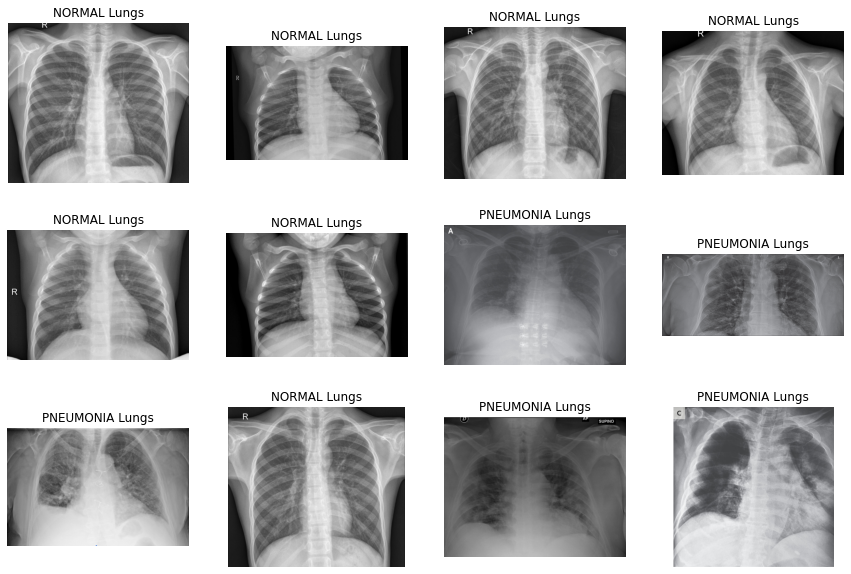

In [10]:
plt.figure(figsize=(15,10))
for i in range(12):
    ran = random.choice(range(1,70))
    rand_normal = [os.path.join(train_normal, f) for f in train_dir_normal[ran:ran+1]]
    rand_pneumonia = [os.path.join(train_pneumonia, f) for f in train_dir_pneumonia[ran:ran+1]]
    rand = random.choice(rand_pneumonia+rand_normal)
    name = rand.split('/')
    name = name[-2] + ' Lungs'
    plt.subplot(3, 4, i+1)
    img = plt.imread(rand)
    plt.imshow(img,cmap = 'gray')
    plt.axis(False)
    plt.title(name)
plt.show()

Sample_Image_size(H*W): (1907, 2165)


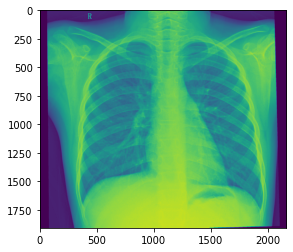

In [11]:
# Looking the size of a random sample image
sample = random.choice(train_dir_normal)
sample = plt.imread(train_normal + sample)
samp = sample.shape
plt.imshow(sample)
print('Sample_Image_size(H*W):', samp)

In [12]:
x, y = [], []
for i in train_dir_normal:
    img_array = plt.imread(train_normal + i)
    shape = img_array.shape
    x.append(shape[0])
    y.append(shape[1])
df_shape = pd.DataFrame({'height': x, 'width': y, 'index': range(0, len(train_dir_normal))})

In [13]:
df_shape.head()

,height,width,index
0,1317,1857,0
1,1509,2111,1
2,1837,2031,2
3,1326,1663,3
4,1818,2053,4


In [14]:
# Looking for the average size
df_shape.describe()

,height,width,index
count,74.000000,74.000000,74.000000
mean,1539.689189,1968.094595,36.500000
std,448.372030,340.261590,21.505813
min,617.000000,1240.000000,0.000000
25%,1255.000000,1765.000000,18.250000
50%,1469.500000,1959.500000,36.500000
75%,1870.750000,2150.750000,54.750000
max,2713.000000,2752.000000,73.000000


In [15]:
#Normalizan los valores entre 0 y 1
train = ImageDataGenerator(rescale=1./255)
test = ImageDataGenerator(rescale=1./255)

In [16]:
tr_dir = covid_path+"train/"
te_dir = covid_path+"test/"

train = train.flow_from_directory(covid_path+"train/", 
                                  target_size = (400,400), 
                                  color_mode = 'grayscale',
                                  batch_size = 10,
                                  class_mode = 'binary')

test = test.flow_from_directory(covid_path+"test/", 
                                target_size = (400,400), 
                                color_mode = 'grayscale', 
                                batch_size = 10,
                                class_mode= 'binary')

Found 148 images belonging to 2 classes.
Found 40 images belonging to 2 classes.


In [17]:
test.class_indices

{'NORMAL': 0, 'PNEUMONIA': 1}

In [18]:
model = keras.models.Sequential([
    keras.layers.Conv2D(32, (5,5), activation = 'relu', input_shape = (400,400, 1)),
    keras.layers.MaxPool2D((2,2)),
    
    keras.layers.Conv2D(64, (3,3), activation = 'relu'),
    keras.layers.MaxPool2D(2,2),
    keras.layers.Conv2D(128, (3,3), activation = 'relu'),
    keras.layers.MaxPool2D((2,2)),
    
    keras.layers.Conv2D(256, (3,3), activation = 'relu'),
    keras.layers.MaxPool2D((2,2)),
    
    keras.layers.Flatten(),
    
    keras.layers.Dense(512, activation = 'relu'),
    
    keras.layers.Dense(1, activation = 'sigmoid')
])

In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 396, 396, 32)      832       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 198, 198, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 196, 196, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 98, 98, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 96, 96, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 48, 48, 128)      0

In [20]:
model.compile(optimizer="adam",
              loss='binary_crossentropy',
              metrics = ['accuracy'])

In [21]:
history = model.fit(
            train, # pass in the training generator
            steps_per_epoch=7,
            epochs=30,
            validation_data=test, # pass in the validation generator
            validation_steps=2,
            verbose=2
            )

Epoch 1/30
7/7 - 13s - loss: 1.8238 - accuracy: 0.4706 - val_loss: 0.6799 - val_accuracy: 0.7000 - 13s/epoch - 2s/step
Epoch 2/30
7/7 - 2s - loss: 0.6945 - accuracy: 0.4853 - val_loss: 0.6770 - val_accuracy: 1.0000 - 2s/epoch - 269ms/step
Epoch 3/30
7/7 - 3s - loss: 0.7025 - accuracy: 0.5441 - val_loss: 0.6374 - val_accuracy: 0.9500 - 3s/epoch - 398ms/step
Epoch 4/30
7/7 - 2s - loss: 0.5021 - accuracy: 0.8714 - val_loss: 0.3780 - val_accuracy: 0.9000 - 2s/epoch - 310ms/step
Epoch 5/30
7/7 - 2s - loss: 0.4128 - accuracy: 0.8286 - val_loss: 0.1876 - val_accuracy: 1.0000 - 2s/epoch - 321ms/step
Epoch 6/30
7/7 - 2s - loss: 0.3239 - accuracy: 0.8714 - val_loss: 0.2017 - val_accuracy: 1.0000 - 2s/epoch - 319ms/step
Epoch 7/30
7/7 - 2s - loss: 0.3413 - accuracy: 0.8571 - val_loss: 0.1185 - val_accuracy: 1.0000 - 2s/epoch - 270ms/step
Epoch 8/30
7/7 - 2s - loss: 0.1653 - accuracy: 0.9559 - val_loss: 0.0617 - val_accuracy: 1.0000 - 2s/epoch - 256ms/step
Epoch 9/30
7/7 - 2s - loss: 0.1917 - accu

Text(0.5, 1.0, 'Loss in training and validation')

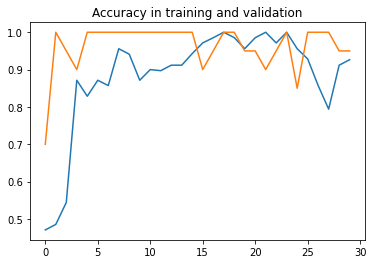

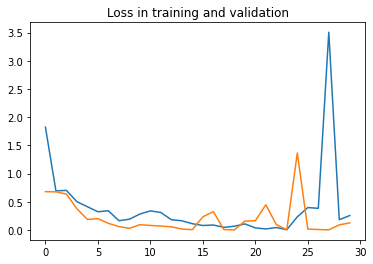

In [22]:
# get the metrics from history

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc)) 

# plot accuracy with matplotlib
plt.plot(epochs, acc)
plt.plot(epochs, val_acc)
plt.title('Accuracy in training and validation')
plt.figure()

# plot loss with matplotlib
plt.plot(epochs, loss)
plt.plot(epochs, val_loss)
plt.title('Loss in training and validation')

In [23]:
def predictImage(filename):
    img1 = image.load_img(filename,target_size=(400,400), color_mode="grayscale")
    
    plt.imshow(img1)
 
    Y = image.img_to_array(img1)
    
    X = np.expand_dims(Y,axis=0)
    val = model.predict(X)
    print(val)
    if val == 1:
        
        plt.xlabel("PNEUMONIA",fontsize=30)
        
    
    elif val == 0:
        
        plt.xlabel("NORMAL",fontsize=30)

1/1 [==============================] - 1s 1s/step
[[1.]]


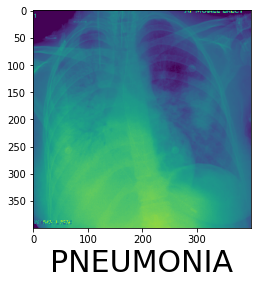

In [26]:
predictImage(Path + "pneumonia-test.jpg")